# Inicialización collab

In [ ]:
# Importación de librerías
# Gestión de archivos y reporte
import os
import shutil
import logging
import yaml

# Manipulación y análisis de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Procesamiento de imágenes
from PIL import Image

# Machine Learning
import tensorflow as tf
#from jupyterlab.semver import valid
#from mistune.markdown import preprocess
#from ray.tune.examples.pbt_tune_cifar10_with_keras import num_classes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#df = pd.read_csv('/content/drive/MyDrive/CV2-PlantVillage/dataframe.csv').set_index('id')

In [ ]:
df_split = pd.read_csv('/content/drive/MyDrive/CV2-PlantVillage/dataframe_splitted.csv').set_index('id')

#### Descarga de dataset de Kaggle

In [ ]:
import kagglehub

# Download latest version
DATASET_PATH = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", DATASET_PATH)

Path to dataset files: /kaggle/input/plantvillage-dataset


In [ ]:
# Ruta de acceso al dataset
ROOT_DIR = f'{DATASET_PATH}/plantvillage dataset/color'

# Dataset split

### Funciones necesarias

In [ ]:
def create_ignore_function(df, train_label, filename_col='filename'):
    """
    Crea y devuelve la función 'ignore_files' que tiene acceso al DataFrame
    y sabe qué archivos mantener.
    """
    # Crea un conjunto (set) con los nombres de archivo que SÍ queremos copiar (ej: split == 'train')
    # Usa este conjunto para hacer la búsqueda de forma mucho más rápida
    files_to_keep = set(df[df['split'] == train_label][filename_col])
    #print(f"Archivos a mantener (split='{train_label}'): {files_to_keep}") # Debugging

    def ignore_files(current_dir, files_in_current_dir):
        """
        Función que será llamada por shutil.copytree.
        Decide qué archivos/directorios ignorar en el directorio actual.
        """
        ignore_list = []
        for item in files_in_current_dir:
            # Construye la ruta completa para verificar si es archivo o directorio
            full_path = os.path.join(current_dir, item)

            # Aplicar la lógica de ignorar SOLO los ARCHIVOS de la lista
            if os.path.isfile(full_path):
                # Si el nombre del archivo NO está en el conjunto de archivos a mantener,
                # entonces lo agrega a la lista de ignorados.
                if item not in files_to_keep:
                    # print(f"Ignorando archivo: {item} (en {current_dir})") # Debugging
                    ignore_list.append(item)

        # print(f"Directorio: {current_dir}, Ignorando: {ignore_list}") # Debugging
        return ignore_list

    # Devuelve la función 'ignore_files' configurada
    return ignore_files


In [ ]:
import os, re

# Busca la carpeta raíz del dataset en el directorio donde fue descargado
def find_path(folder):
    match = re.search(fr"^(.*?)/{folder}/", DATASET_PATH)
    if match:
        prefix = match.group(1)
        path = os.path.join(prefix, f"{folder}/")
        return path
    else:
        print(f'No se ha podido encontrar la carpeta "{folder}" en {DATASET_PATH}')
        return None
# Carga de imagenes en memoria y visualización
def load_image(data: pd.DataFrame, index: int, root: str=ROOT_DIR):
    """
    Carga una imagen PIL desde una fila específica de un DataFrame.

    Args:
        dataframe (pandas.DataFrame): El DataFrame que contiene las rutas de las imágenes.
        index (int): El índice de la fila en el DataFrame para cargar la imagen.
        root_dir (str): El directorio raíz donde se encuentran las imágenes.

    Returns:
        PIL.Image.Image: La imagen cargada como un objeto PIL.Image, o None si ocurre un error.
    """
    if index < 0 or index >= len(data):
        print("Índice fuera de rango.")
        return None

    row = data.iloc[index]
    relative_path = row['image_path']
    filename = row['filename']
    full_path = os.path.join(root, relative_path, filename)

    try:
        img = Image.open(full_path)
        return img
    except FileNotFoundError:
        print(f"Archivo no encontrado: {full_path}")
        return None
    except Exception as e:
        print(f"Error al cargar la imagen: {e}")
        return None

## Split de archivos

In [ ]:
# Guarda directorio del dataset dividido
path = find_path("plantvillage-dataset")
DATASETS_ROOT = path
SPLITTED_PATH = f"{path}splitted/" if path else None

No se ha podido encontrar la carpeta "plantvillage-dataset" en /kaggle/input/plantvillage-dataset


In [ ]:
splits = df_split['split'].value_counts().index.tolist()
splits

['train', 'test']

In [ ]:
verfication = True # Ejecuta el proceso de verificación (punto 2)

print(f"Se inicia proceso de copiado del dataset…")
total_files = len(df_split) # Total de archivos del dataset
print(f" - Total de archivos en el dataset: {total_files}")

# Realiza el proceso de copiado de archivos para cada split
succeeded_process = True
for split in splits:
    # Crea las rutas de origen y destino
    # (Ejemplo: 'train', 'test', 'valid')
    print(f"\n\nIniciando proceso para '{split}' split …")
    source_folder = f'{ROOT_DIR}/'
    destination_folder = f'{SPLITTED_PATH}{split}/'
    total_split = len(df_split[df_split['split'] == split]) # Total de archivos del split
    # Se omite verificación de existencia del dataset (porque se crea siempre desde cero)
    print(f"🔄 Procesando split '{split.upper()}' ({(total_split/total_files*100):.2f}):")
    print(f"  - Total de archivos a copiar: {total_split}")
    succeeded = False

    try:
        print(f"1. Creando estructura de subcarpetas:")
        # 1. Crea la función para ignorar específica para el split a procesar
        ignore_function = create_ignore_function(df_split, train_label=split, filename_col='filename')
        print(f"    ✔ Función de filtro creada para el split ")

        # 2. Con copytree copia todo el "árbol" de directorios (careptas y subcarpetas)
        # Fitrando con ignore_function todos aquellos archivos que no pertenecen al split deseado
        print(f"    ∞ Copiando contenido del dataset (puede demorar hasta un minuto).")
        shutil.copytree(source_folder, destination_folder, ignore=ignore_function)
        print(f"    ✔ Proceso de copiado del split finalizado.")

        if verfication:
            # Verifica qué se haya copiado adecuadamente (opcional pero útil)
            print(f"2. Se inicia proceso de verificación…")
            copied_files = []
            for root, dirs, files_in_dest in os.walk(destination_folder):
                for name in files_in_dest:
                    copied_files.append(os.path.join(os.path.relpath(root, destination_folder), name).replace('\\', '/')) # Normalizar path
                    #print(f"  - {os.path.join(root, name)}") # Debuggin
            print(f"    ✔ Se crearon un total de {len(os.listdir(destination_folder))} carpetas (para las clases).")
            print(f"    ✔ Se copiaron un total de {len(copied_files)} archivos ({len(copied_files)/total_split*100:.2f}%)")
            # Agregar confirmación de igualdad cantidad split == copiados
            if len(copied_files) == total_split:
                print(f"✅ Se completó satisfactoriamente el subproceso de copiado para el split.\n")
                succeeded = True
            else:
                print(f"❌ Error: No se pudo copiar correctamente el split '{split.upper()}'\n")
                succeeded = False
        else:
            succeeded = True # Si la verificación está desactivada, se asume que el proceso fue exitoso

    except FileExistsError:
        print(f"Error: La carpeta de destino '{destination_folder}' ya existe.\n")
        pass
    except Exception as e:
        print(f"Ocurrió un error inesperado: {e}\n")

    succeeded_process *= succeeded # Actualiza el estado del proceso
    # (Sólo es 'True' si todos los splits se copian correctamente)

if succeeded_process:
    print("\n\n🌟 El proceso de copiado del dataset ha finalizado con éxito.\n")
else:
    print("\n\n🚫 No se pudo completar satisfactoriamente el proceso de copiado del dataset.\nVerificar que se haya completado la eliminación de las carpetas.\n")

Se inicia proceso de copiado del dataset…
 - Total de archivos en el dataset: 54305


Iniciando proceso para 'train' split …
🔄 Procesando split 'TRAIN' (80.00):
  - Total de archivos a copiar: 43444
1. Creando estructura de subcarpetas:
    ✔ Función de filtro creada para el split 
    ∞ Copiando contenido del dataset (puede demorar hasta un minuto).
    ✔ Proceso de copiado del split finalizado.
2. Se inicia proceso de verificación…
    ✔ Se crearon un total de 38 carpetas (para las clases).
    ✔ Se copiaron un total de 43444 archivos (100.00%)
✅ Se completó satisfactoriamente el subproceso de copiado para el split.



Iniciando proceso para 'test' split …
🔄 Procesando split 'TEST' (20.00):
  - Total de archivos a copiar: 10861
1. Creando estructura de subcarpetas:
    ✔ Función de filtro creada para el split 
    ∞ Copiando contenido del dataset (puede demorar hasta un minuto).
    ✔ Proceso de copiado del split finalizado.
2. Se inicia proceso de verificación…
    ✔ Se crearon un t

---

# Data Augmentation

In [ ]:
import os
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import random
import yaml
import shutil
from PIL import Image
import pandas as pd

### Funciones necesarias

In [ ]:
def find_folder(path):
    return os.path.basename(os.path.dirname(path))

In [ ]:
# Carga de imagenes en memoria y visualización
def load_image(data: pd.DataFrame, index: int, root: str=ROOT_DIR):
    """
    Carga una imagen PIL desde una fila específica de un DataFrame.

    Args:
        dataframe (pandas.DataFrame): El DataFrame que contiene las rutas de las imágenes.
        index (int): El índice de la fila en el DataFrame para cargar la imagen.
        root_dir (str): El directorio raíz donde se encuentran las imágenes.

    Returns:
        PIL.Image.Image: La imagen cargada como un objeto PIL.Image, o None si ocurre un error.
    """
    # if index < 0 or index >= len(data):
    #     print("Índice fuera de rango.")
    #     return None

    row = data.iloc[index]
    relative_path = row['image_path']
    filename = row['filename']
    full_path = os.path.join(root, relative_path, filename)

    try:
        img = Image.open(full_path)
        return img
    except FileNotFoundError:
        print(f"Archivo no encontrado: {full_path}")
        return None
    except Exception as e:
        print(f"Error al cargar la imagen: {e}")
        return None

In [ ]:
# Carga de imagenes en memoria y visualización
def load_image_idx(data, root: str=ROOT_DIR):
    """
    Carga una imagen PIL desde una fila específica de un DataFrame.

    Args:
        dataframe (pandas.DataFrame): El DataFrame que contiene las rutas de las imágenes.
        index (int): El índice de la fila en el DataFrame para cargar la imagen.
        root_dir (str): El directorio raíz donde se encuentran las imágenes.

    Returns:
        PIL.Image.Image: La imagen cargada como un objeto PIL.Image, o None si ocurre un error.
    """
    # if index < 0 or index >= len(data):
    #     print("Índice fuera de rango.")
    #     return None

    row = data
    relative_path = row['image_path']
    filename = row['filename']
    full_path = os.path.join(root, relative_path, filename)

    try:
        img = Image.open(full_path)
        return img
    except FileNotFoundError:
        print(f"Archivo no encontrado: {full_path}")
        return None
    except Exception as e:
        print(f"Error al cargar la imagen: {e}")
        return None

In [ ]:
def filter_classes(df, target, range: tuple = (0,None)):
    lim_min, lim_max = range
    counts = df[target].value_counts()
    if lim_min == None:
        lim_min  = 0
    if lim_max == None:
        lim_max  = counts.max()
    #print("Limites:", lim_min, lim_max)

    selection = []
    for idx, count in enumerate(counts):
        if lim_min < count <= lim_max:
            clase = counts.index[idx]
            selection.append(clase)
    return selection

In [ ]:
def numoji(numero):
  """
  Convierte un número entero del 1 al 10 a su emoji correspondiente.

  Args:
    numero: Un entero entre 1 y 10.

  Returns:
    Un string con el emoji correspondiente al número, o "0️⃣" si el número
    está fuera del rango.
  """
  if 1 <= numero <= 10:
    emoji_map = {
        1: "1️⃣",
        2: "2️⃣",
        3: "3️⃣",
        4: "4️⃣",
        5: "5️⃣",
        6: "6️⃣",
        7: "7️⃣",
        8: "8️⃣",
        9: "9️⃣",
        10: "🔟"
    }
    return emoji_map[numero]
  else:
    return "*️⃣"

----

## Transformaciones

In [ ]:
# 1. Define las transformaciones de Albumentations
transform = A.Compose([
    A.Rotate(limit=180, p=0.5),          # Rotación aleatoria hasta 180 grados con probabilidad 0.5
    A.HorizontalFlip(p=0.5),            # Volteo horizontal con probabilidad 0.5
    A.VerticalFlip(p=0.5),              # Volteo vertical con probabilidad 0.5
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3), # Ajuste de brillo y contraste aleatorio
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3), # Ajuste de tono, saturación y valor
    A.RandomCrop(width=200, height=200, p=0.3), # Recorte aleatorio a 200x200
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),   # Desenfoque Gaussiano
    A.RandomScale(scale_limit=0.1, p=0.3),      # Escalado aleatorio con un límite de 10%
])

In [ ]:
def apply_transformations(original_image):
    # Convertir la imagen original a un array NumPy para la transformación
    original_image_array = np.array(original_image)

    # Aplicar las transformaciones
    transformed = transform(image=original_image_array)
    return transformed['image']

----
# Procesamiento del dataset

## Creación de directorios y estructuras de datos

In [ ]:
# Se ha definido una nueva constante con la ubicación del dataset aumentado (será almacenadad en YAML)
AUG_PATH = SPLITTED_PATH

Luego, se aplican las transformaciones para aumentación de datos a la copia del dataset.

In [ ]:
# Agrega columnas para indicar procesamiento
## original -> imagen sin transofrmaciones
## augmented -> existen aumentaciones derivadas
df_split['augmented'] = False
df_split['is_original'] = True

# Crea un nuevo dataframe para gesitonar el procesamiento
process_split = df_split[df_split['split']=='train'].copy()
process_split

,image_path,filename,class,group,tag,split,augmented,is_original
id,,,,,,,,
0,Strawberry___healthy/,8f558908-aa1b-4a86-855a-5094c2392e5a___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train,False,True
2,Strawberry___healthy/,abdd34a0-ab02-41e0-95a3-a014ab863ec2___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train,False,True
3,Strawberry___healthy/,d1aee44a-b6bb-45b9-b7b6-5d553add8fd1___RS_HL 2...,Strawberry___healthy,Strawberry,healthy,train,False,True
4,Strawberry___healthy/,3d28c3ea-8419-4e09-addd-211e3828e39f___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train,False,True
5,Strawberry___healthy/,4005fb13-0d7c-4a30-9ee3-73e9e4cee05e___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train,False,True
...,...,...,...,...,...,...,...,...
54299,Soybean___healthy/,39d15a45-c9f2-4933-b31e-fde13e0141b1___RS_HL 2...,Soybean___healthy,Soybean,healthy,train,False,True
54300,Soybean___healthy/,57c18b39-2a33-471f-91eb-a9ba4ddabc7b___RS_HL 6...,Soybean___healthy,Soybean,healthy,train,False,True
54301,Soybean___healthy/,4fdc663e-a8ea-4d8a-801b-ef18ad192661___RS_HL 6...,Soybean___healthy,Soybean,healthy,train,False,True


In [ ]:
# Crea una columna 'ref' que apunta al id de la imagen original
process_split['ref'] = process_split.index
process_split

,image_path,filename,class,group,tag,split,augmented,is_original,ref
id,,,,,,,,,
0,Strawberry___healthy/,8f558908-aa1b-4a86-855a-5094c2392e5a___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train,False,True,0
2,Strawberry___healthy/,abdd34a0-ab02-41e0-95a3-a014ab863ec2___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train,False,True,2
3,Strawberry___healthy/,d1aee44a-b6bb-45b9-b7b6-5d553add8fd1___RS_HL 2...,Strawberry___healthy,Strawberry,healthy,train,False,True,3
4,Strawberry___healthy/,3d28c3ea-8419-4e09-addd-211e3828e39f___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train,False,True,4
5,Strawberry___healthy/,4005fb13-0d7c-4a30-9ee3-73e9e4cee05e___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train,False,True,5
...,...,...,...,...,...,...,...,...,...
54299,Soybean___healthy/,39d15a45-c9f2-4933-b31e-fde13e0141b1___RS_HL 2...,Soybean___healthy,Soybean,healthy,train,False,True,54299
54300,Soybean___healthy/,57c18b39-2a33-471f-91eb-a9ba4ddabc7b___RS_HL 6...,Soybean___healthy,Soybean,healthy,train,False,True,54300
54301,Soybean___healthy/,4fdc663e-a8ea-4d8a-801b-ef18ad192661___RS_HL 6...,Soybean___healthy,Soybean,healthy,train,False,True,54301


## Estrategia de aumentación

Dado que el dataset original está desbalanceado, se aplicará la aumentación de datos sólo a las clases minoritarias como forma de compensar el desbalance.

In [ ]:
### Resumen distribucion por grupo
print("Conteo por grupo:")
print(df_split['group'].value_counts())

Conteo por grupo:
group
Tomato                     18160
Orange                      5507
Soybean                     5090
Grape                       4062
Corn_(maize)                3852
Apple                       3171
Peach                       2657
Pepper,_bell                2475
Potato                      2152
Cherry_(including_sour)     1906
Squash                      1835
Strawberry                  1565
Blueberry                   1502
Raspberry                    371
Name: count, dtype: int64


In [ ]:
# Clases a las que se le aplicará aumentación de datos
# Entre 4000 y 2000
group1 = {
    'classes': filter_classes(df_split,'group',(2000,4000)),
    'increase': 2 # 2x data augmentation (original + transf)
}
# Menores a 2000
group2 = {
    'classes': filter_classes(df_split,'group',(500,2000)),
    'increase': 3 # 3x data augmentation (original +  2 transf)
}

# Clase mínima (Raspberry)
group3 = {
    'classes': filter_classes(df_split,'group',(0,500)),
    'increase': 6 # 6x data augmentation (original +  5 transf)
}

In [ ]:
print("Efecto de la aumentación de datos para 'train' split\n")
counts = df_split[df_split['split']=='train']['group'].value_counts()

groups = [group1, group2, group3]
for group in groups:
    mult = group['increase']
    print(f"Estrategia de aumentación {mult}x:")
    for clase in group['classes']:
        print(f" - {clase}: {counts[clase]} -> {counts[clase]*mult}")
    print()

Efecto de la aumentación de datos para 'train' split

Estrategia de aumentación 2x:
 - Corn_(maize): 3081 -> 6162
 - Apple: 2537 -> 5074
 - Peach: 2125 -> 4250
 - Pepper,_bell: 1980 -> 3960
 - Potato: 1722 -> 3444

Estrategia de aumentación 3x:
 - Cherry_(including_sour): 1525 -> 4575
 - Squash: 1468 -> 4404
 - Strawberry: 1252 -> 3756
 - Blueberry: 1202 -> 3606

Estrategia de aumentación 6x:
 - Raspberry: 297 -> 1782



In [ ]:
def gen_rnd_id():
    """
        Genera un número aleatorio de 6 cífras que se usará para diferenciar imagenes procesados de las originales
    """
    rnd_seed = round(time.time() * 1e10) # Use clock as seed generator
    random.seed(rnd_seed)  # Set this value as a new seed (assure better randomization)
    sampled_numbers = random.sample(range(int(1e6)), 1)  # Generates a random number
    return sampled_numbers[0]

In [ ]:
import humanize

# Traducir humanize al español
try:
    humanize.i18n.activate("es")
except FileNotFoundError:
    print("Paquete de idioma español para humanize no encontrado, usando inglés.")
    humanize.i18n.activate("en_US") # Fallback a inglés

## Procesamiento de aumentaciones

In [ ]:
# PROCESAMIENTO DE AUMENTACIONES CON FILTRADO POR CLASE
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# SETUP INCIAL:
verbose = True # Incluye detalle del proceso y estimación de tiempo
testing = False # No modifica archivos
debugging = False # Incluye detalle de archivos y mensajes de error
processes = [group1, group2, group3] # Estrategias a aplicar
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for_processing_classes = [cls for group in groups for cls in group['classes']]
for_processing_data = process_split[process_split['group'].isin(for_processing_classes)]
n_transformations = 0
for process in processes:
    classes, increase = process['classes'], process['increase']
    images_in_classes = for_processing_data[for_processing_data['group'].isin(classes)]
    n_transformations += len(images_in_classes) * (increase - 1)

print(f"Iniciando proceso de aumentación de datos…")
folder = f'{AUG_PATH}train/'
print(f"Aumentando imágenes para:\n >>", folder)
total_files = len(for_processing_data) # Total de archivos del dataset
print(f" - Total de archivos en el dataset 'train': {len(process_split)}")
print(f" - Total de archivos en a procesar: {total_files} ({(total_files/len(process_split)*100):.0f}% del dataset)")
print(f" - Transformaciones totales: {n_transformations} imágenes serán creadas\n")
print(f"Se procesarán un total de {len(for_processing_classes)} clases de {len(process_split['group'].value_counts())}:")
for label in for_processing_classes:
    print(" - ",label)
print()
for i, process in enumerate(processes):
    print(f"· Estrategia {i+1}: {process['increase']}x aumentation para {process['classes']}")
print("\n¿Deseas iniciar el procesamiento?")

# Input de confirmación del usuario
confirmacion = input(f"⚠️ ATENCIÓN: El proceso puede demorar varios minutos. Se requiere confirmación para continuar [Y/N]: ").strip().lower()
if confirmacion != 'y':
    print(f"\n⛔️ La ejecución ha sido denegada por el usuario.")
else:
    start_time = time.perf_counter() # Medición del tiempo
    partial_time = start_time #?

    # PROCESAMIENTO DE AUMENTACIONES
    # Leyenda:
    #  count -> archivos originales procesados (total)
    #  work -> transformaciones por clase (parcial)
    #  task -> número de transformaciones por archivo

    # Duplica dataframe para almacenar el proceso
    processed_split = process_split.copy()

    # Realiza el proceso de copiado de archivos para cada grupo
    succeeded_process = True
    count = 0
    total_work_done = 0
    avg_time = 0
    partial_time = 0
    previous_count = 0
    spacer1 = '   '
    spacer2 = '      '

    for i, process in enumerate(processes):
        mult = process['increase']
        n_aumentations = mult - 1 # se resta 1 porque la imagen original ya existe
        classes = process['classes']
        print(f"\n\n{numoji(i+1)} Iniciando subproceso de aumentación:")
        print(f" - Estrategia de aumentación: {mult}x")
        print(f" - Clases a procesar: {len(classes)} grupos\n   {classes}")

        for clase in classes:
            # Filtrado de clases
            subprocess_split = process_split[process_split['group']==clase]
            total_work = len(subprocess_split) * n_aumentations # Conteo de archivos para la clase
            print(f"\n{spacer1}🔄 Procesando clase '{clase}' ({(total_work/total_files*100):.0f}% del total):")
            print(f"{spacer1}  - Transformaciones a generar: {total_work}") if verbose else None
            work = 0

            for index, image_row in subprocess_split.iterrows():
                if work==0 and testing:
                    print(f"{spacer2}(+) TESTING: omite la apertura de la imagen.")
                    print(f"{spacer2}(+) TESTING: omite las transformaciones.")
                # 1. Apertura del archivo de imagen original
                original_image = load_image_idx(data=image_row,root=folder) if not testing else None
                #original_image.show() # Debugging

                # Genera múltiples transformaciones para cada imagen
                try:
                    task = n_aumentations
                    for n in range(n_aumentations):

                        # 2. Procesamiento de la transformacion
                        transformed_image = apply_transformations(original_image) if not testing else None
                        try:
                            # Convierte el array NumPy a un objeto Image de PIL
                            if not testing:
                                if transformed_image.ndim == 2:  # Escala de grises
                                    processed_image = Image.fromarray(transformed_image.astype(np.uint8), 'L')
                                elif transformed_image.ndim == 3:  # RGB
                                    if transformed_image.shape[2] == 3:
                                        processed_image = Image.fromarray(transformed_image.astype(np.uint8), 'RGB')
                                    else:
                                        raise ValueError(f"{spacer2}❗️El array NumPy debe tener 2 (escala de grises) o 3 (RGB) canales.")
                                else:
                                    raise ValueError(f"{spacer2}❗️ El array NumPy debe tener 2 o 3 dimensiones.")
                                #processed_image.show() # Debugging

                            # 3. Almacena el archivo
                            # Genera el nombre del nuevo archivo
                            # se incluye un int random al final (para permitir múltiples aumentaciones)
                            rnd_num = str(gen_rnd_id()).zfill(6) # string de 6 cifras
                            name = list(os.path.splitext(image_row.filename))
                            name.insert(1,f'-{rnd_num}')
                            filename = "".join(name)
                            # Guarda la transformación como JPG
                            processed_image.save(f'{folder}{image_row.image_path}{filename}', "JPEG") if not testing else None
                            print(f"{spacer2}🔹 {filename}") if debugging else None

                            # 4. Registra la nueva imagen en el DataFrame
                            new_row = image_row.copy() # Copia las etiquetas
                            # Actualiza los valores correspondientes
                            new_row['filename'] = filename
                            new_row['is_original'] = False
                            new_row['augmented'] = True
                            # Agrega la nueva fila al DataFrame processed_split
                            processed_split = pd.concat([processed_split, pd.DataFrame([new_row])], ignore_index=True)

                            task -= 1 # cuenta una transformación finalizada
                            work += 1 # cuenta una aumentación realizada (por clase)
                            if work % 100 == 0:
                                print(f'{spacer2}🔨 » Progreso subproceso: {work/total_work*100:.2f}%') if verbose else None

                        except FileExistsError:
                            print(f"{spacer2}❌ Error: El archivo de destino '{destination_folder}' ya existe.\n") if debugging else None
                            continue
                        except Exception as e:
                            print(f"{spacer2}❌ Error al guardar la imagen como JPG: {e}") if debugging else None
                            continue
                finally:
                    # 5. Actualiza el registro de la imagen original
                    processed_split.loc[index, 'augmented'] = True
                    #print(processed_split.iloc[index])

                    count += 1 # cuenta un archivo finalizado
                    if task == 0:
                        pass
                    else:
                        print(f"{spacer2}‼️ ALERTA: No se ha completado la tarea para {image_row.filename}")

            print(f'{spacer2}🔨 » Progreso subproceso: 100%') if verbose else None
            total_work_done += work # registro del trabajo realizado

            # LÓGICA TEMPORAL
            if verbose:
                # Medición de tiempo pasado y estimación del faltante
                previous_time = partial_time
                partial_time = time.perf_counter() # Medición del tiempo
                divisor = count - previous_count
                elapsed_time = (partial_time - start_time)
                task_time = elapsed_time/divisor if divisor > 0 else 0
                #avg_time = elapsed_time/count if count > 0 else 0 # Tiempo medio para estimación
                avg_time = elapsed_time/total_work_done if total_work_done > 0 else 0 # Tiempo medio para estimación

                print(f'{spacer2}⏱️ · Tiempo de suproceso {humanize.naturaldelta(avg_time)}')
                if previous_count and verbose:
                    if task_time > avg_time*1.1:
                        print(f"{spacer2}👎🏻 La tarea ha demorado más de lo esperado…")
                    elif task_time < avg_time*0.75:
                        print(f"{spacer2}👍🏻 ¡Tarea completada en tiempo record!")

            if work == total_work:
                print(f"{spacer1}✅ Subproceso de transfromaciones completado.")
                succeeded = True
            else:
                print(f"{spacer1}‼️ ALERTA: No se pudo completar correctamente el subproceso de transfromaciones.")
                succeeded = False
            if verbose:
                #print(f'\n{spacer1}🕗 Ejecución total {elapsed_time/60:.1f} min')
                print(f'\n{spacer1}🕗 Ejecución total {humanize.naturaldelta(elapsed_time)}')
                #print(f'{spacer1}🔮 Estimación de tiempo restante {avg_time * (n_transformations - total_work_done) / 60:.2f} min')
                print(f'{spacer1}🔮 Estimación de tiempo restante {humanize.naturaldelta(avg_time * (n_transformations - total_work_done))}')
                print(f'{spacer1}❇️ » Progreso general: {count/total_files*100:.3f}%') if (count/total_files) < 0.99 else None
            previous_count = count

            succeeded_process *= succeeded # Actualiza el estado del proceso
            # (Sólo es 'True' si todos los subprocesos se completan correctamente)

    print(f'{spacer1}❇️ » Progreso general: 100%') if not testing else None
    end_time = time.perf_counter() # Medición del tiempo
    total_time = end_time - start_time
    if succeeded_process:
        print("\n🌟 El proceso de aumentación del dataset ha finalizado con éxito.")
    else:
        print("\n🚫 No se pudo completar satisfactoriamente el proceso de aumentación del dataset.")
    if verbose:
        print(f'{spacer1}🕗 Ejecución completada en {humanize.naturaldelta(total_time)}')
        print(f'{spacer1}🔢 · Se procesaron {total_work_done} transformaciones para un total de {total_files} imágenes.')
        print(f'{spacer1}⏱️ · Tiempo medio por transofrmación {(total_time/total_work_done):.3f} sec')

Iniciando proceso de aumentación de datos…
Aumentando imágenes para:
 >> Nonetrain/
 - Total de archivos en el dataset 'train': 43444
 - Total de archivos en a procesar: 17189 (40% del dataset)
 - Transformaciones totales: 23824 imágenes serán creadas

Se procesarán un total de 10 clases de 14:
 -  Corn_(maize)
 -  Apple
 -  Peach
 -  Pepper,_bell
 -  Potato
 -  Cherry_(including_sour)
 -  Squash
 -  Strawberry
 -  Blueberry
 -  Raspberry

· Estrategia 1: 2x aumentation para ['Corn_(maize)', 'Apple', 'Peach', 'Pepper,_bell', 'Potato']
· Estrategia 2: 3x aumentation para ['Cherry_(including_sour)', 'Squash', 'Strawberry', 'Blueberry']
· Estrategia 3: 6x aumentation para ['Raspberry']

¿Deseas iniciar el procesamiento?
⚠️ ATENCIÓN: El proceso puede demorar varios minutos. Se requiere confirmación para continuar [Y/N]: y


1️⃣ Iniciando subproceso de aumentación:
 - Estrategia de aumentación: 2x
 - Clases a procesar: 5 grupos
   ['Corn_(maize)', 'Apple', 'Peach', 'Pepper,_bell', 'Potato']

# Verificación

Ahora, verificamos el proceso de aumentación.

In [ ]:
resut_aug_dataframe = len(processed_split) - len(process_split)
print(f"Luego del proceso de aumentación de datos se genraron {resut_aug_dataframe} archivos nuevos.")

Luego del proceso de aumentación de datos se genraron 23824 archivos nuevos.


In [ ]:
# prompt: count every file in a folder directory (including subfolders)

import os

def count_files(directory):
  """Counts the number of files in a directory, including subdirectories.

  Args:
    directory: The path to the directory.

  Returns:
    The total number of files in the directory and its subdirectories.
  """
  total_files = 0
  for root, _, files in os.walk(directory):
    total_files += len(files)
  return total_files

# Example usage: Replace 'your_directory' with the actual directory path
directory_path = '/content/Nonetest'
file_count = count_files(directory_path)
print(f"Test dataset '{directory_path}': {file_count}")

directory_path = '/content/Nonetrain'
file_count = count_files(directory_path)
print(f"Train dataset '{directory_path}': {file_count}")


Test dataset '/content/Nonetest': 10861
Train dataset '/content/Nonetrain': 67268


In [ ]:
processed_split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67268 entries, 0 to 67267
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_path   67268 non-null  object
 1   filename     67268 non-null  object
 2   class        67268 non-null  object
 3   group        67268 non-null  object
 4   tag          67268 non-null  object
 5   split        67268 non-null  object
 6   augmented    67268 non-null  bool  
 7   is_original  67268 non-null  bool  
 8   ref          67268 non-null  int64 
dtypes: bool(2), int64(1), object(6)
memory usage: 3.7+ MB


In [ ]:
processed_split.describe()

,ref
count,67268.000000
mean,27259.484421
std,16115.637606
min,0.000000
25%,12098.750000
50%,27720.500000
75%,42121.250000
max,54304.000000


In [ ]:
processed_split[(processed_split['is_original'] == False)].sample(5)

,image_path,filename,class,group,tag,split,augmented,is_original,ref
47934,Apple___healthy/,8eb47c92-87b8-4c92-a6a1-faf62e651e3e___RS_HL 8...,Apple___healthy,Apple,healthy,train,True,False,46544
58838,Squash___Powdery_mildew/,ccfc11ca-5357-4036-9215-b32fab63ab31___MD_Powd...,Squash___Powdery_mildew,Squash,Powdery_mildew,train,True,False,43900
55359,Cherry_(including_sour)___Powdery_mildew/,c1ec1b39-c8c6-44a6-ad13-9553496844fa___FREC_Pw...,Cherry_(including_sour)___Powdery_mildew,Cherry_(including_sour),Powdery_mildew,train,True,False,19653
61897,Strawberry___Leaf_scorch/,62114343-a924-445c-9a9a-9103fc797414___RS_L.Sc...,Strawberry___Leaf_scorch,Strawberry,Leaf_scorch,train,True,False,48140
48406,Apple___healthy/,0f56566e-6151-4ede-b10b-2b1f04f23659___RS_HL 7...,Apple___healthy,Apple,healthy,train,True,False,47128


In [ ]:
# MERGE DEL DATAFRAME AUMENTADO CON EL ORIGINAL
# 1. Se pararan los datos de archivos procesados
for_update = processed_split[processed_split['is_original']==True]
new_rows = processed_split[processed_split['is_original']==False]

# 2. Se actualiza el Dataframe original con los nuevos valores
df_split.update(for_update)

# 3. Se agregan las aumentaciones con el dataframe original
df_augmented = pd.concat([df_split, new_rows], axis=0)
df_augmented.update(for_update)

# 4. (Opcional) Reordenar por índice si querés mantener orden
df_augmented['ref'] = df_augmented['ref'].astype('Int64')
# df_merged = df_merged.sort_index()

In [ ]:
#df_augmented.to_csv('df_augmented.csv')

In [ ]:
df_augmented.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78129 entries, 0 to 67267
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_path   78129 non-null  object
 1   filename     78129 non-null  object
 2   class        78129 non-null  object
 3   group        78129 non-null  object
 4   tag          78129 non-null  object
 5   split        78129 non-null  object
 6   augmented    78129 non-null  bool  
 7   is_original  78129 non-null  bool  
 8   ref          67268 non-null  Int64 
dtypes: Int64(1), bool(2), object(6)
memory usage: 5.0+ MB


In [ ]:
# Verificamos que el Dataset original + Aumentación coincidan con los registros del dataframe final
len_entrada = len(df_split)
len_augmentado = len_entrada + resut_aug_dataframe
len_salida = len(df_augmented)
if len_salida != len_augmentado:
    raise ValueError(f'‼️ ALERTA: Se detectó una discrepancia en el dataframe:\n - Datos originales {len_entrada}\n - Datos aumentados {resut_aug_dataframe}\n - Datos de salida {len_salida}')
else:
    print(f"✅ Verificación exitosa. Se verificaron {len_salida} archivos en dataframe.")

✅ Verificación exitosa. Se verificaron 78129 archivos en dataframe.


## Distribución por clase

In [ ]:
### Resumen distribucion por grupo
print("Conteo por grupo:")
print(df_augmented['group'].value_counts())

Conteo por grupo:
group
Tomato                     14529
Soybean                     9162
Apple                       7340
Corn_(maize)                6675
Squash                      6135
Strawberry                  4865
Cherry_(including_sour)     4575
Orange                      4405
Peach                       4250
Pepper,_bell                3960
Blueberry                   3606
Potato                      3596
Grape                       3249
Raspberry                   1782
Name: count, dtype: int64


In [ ]:
print("Efecto de la aumentación de datos por clase:\n")
counts_entrada = df_split['group'].value_counts()
counts_salida = df_augmented['group'].value_counts()

classes = counts_salida.index
for class_ in classes:
    print(f" - {class_}: {counts_entrada[class_]} -> {counts_salida[class_]} (+{(counts_salida[class_]/counts_entrada[class_]-1)*100:.0f}%)")

Efecto de la aumentación de datos por clase:

 - Tomato: 14529 -> 14529 (+0%)
 - Soybean: 9162 -> 9162 (+0%)
 - Apple: 4803 -> 7340 (+53%)
 - Corn_(maize): 3594 -> 6675 (+86%)
 - Squash: 3199 -> 6135 (+92%)
 - Strawberry: 2361 -> 4865 (+106%)
 - Cherry_(including_sour): 1525 -> 4575 (+200%)
 - Orange: 4405 -> 4405 (+0%)
 - Peach: 2125 -> 4250 (+100%)
 - Pepper,_bell: 1980 -> 3960 (+100%)
 - Blueberry: 1202 -> 3606 (+200%)
 - Potato: 1874 -> 3596 (+92%)
 - Grape: 3249 -> 3249 (+0%)
 - Raspberry: 297 -> 1782 (+500%)


----
# Training model

## Dataloader

In [ ]:
import tensorflow as tf

In [ ]:
# Data laoders setup
def load_from_directory(data_folder):
    """
    Carga un dataset de imágenes desde un directorio específico.

    Args:
        data_folder (str): Ruta al directorio que contiene las imágenes.

    Returns:
        tf.data.Dataset: Dataset de TensorFlow con las imágenes y etiquetas.
    """
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_folder,  # Ruta al directorio de datos
        labels="inferred",  # Las etiquetas se infieren automáticamente desde los nombres de las carpetas
        label_mode="categorical",  # Las etiquetas se codifican como categorías (one-hot encoding)
        class_names=None,  # Las clases se detectan automáticamente
        color_mode="rgb",  # Las imágenes se cargan en modo RGB
        batch_size=128,  # Tamaño de lote para el entrenamiento
        image_size=(256, 256),  # Redimensiona las imágenes a 128x128 píxeles
        shuffle=True,  # Mezcla las imágenes aleatoriamente
        seed=42,  # No se utiliza una semilla específica para la aleatorización
        validation_split=None,  # No se realiza una división de validación aquí
        subset=None,  # No se especifica un subconjunto (train/validation)
        interpolation="bilinear",  # Método de interpolación para redimensionar las imágenes
        follow_links=False,  # No sigue enlaces simbólicos
        crop_to_aspect_ratio=False  # No recorta las imágenes para ajustar la relación de aspecto
    )

    return dataset

In [ ]:
# Carga el dataset de imágenes desde el directorio especificado
train_images = ""; test_images = ""; valid_images = ""

print("Cargando datasets desde el directorio…\n")
for split in splits:
    data_folder = f'{SPLITTED_PATH}{split}/'

    # Carga el conjunto de datos desde el directorio especificado
    # Utiliza la función de TensorFlow para crear un dataset de imágenes
    match split:
        case 'train':
            print(f"Cargando dataset de entrenamiento desde:\n > {data_folder}")
            train_images = load_from_directory(data_folder)
        case 'test':
            print(f"Cargando dataset de test desde:\n > {data_folder}")
            test_images = load_from_directory(data_folder)
        case 'valid':
            print(f"Cargando dataset de validación desde:\n > {data_folder}")
            valid_images = load_from_directory(data_folder)
        case _: # En caso de no coincidir con ninguno de los splits
            print(f"⚠️ El split '{split}' no es reconocido. No se cargará ningún dataset.")
            continue # Salta al siguiente split
    print(f"✅ Dataset cargado exitosamente.\n")

Cargando datasets desde el directorio…

Cargando dataset de entrenamiento desde:
 > Nonetrain/
Found 67268 files belonging to 38 classes.
✅ Dataset cargado exitosamente.

Cargando dataset de test desde:
 > Nonetest/
Found 10861 files belonging to 38 classes.
✅ Dataset cargado exitosamente.



In [ ]:
print("Resumen de los datasets cargados:")
print(f" - Total de imágenes en el dataset de entrenamiento: {len(train_images)}")
print(f" - Total de imágenes en el dataset de validación: {len(valid_images)}")
print(f" - Total de imágenes en el dataset de test: {len(test_images)}")
print(f"Total de imágenes cargadas: {len(train_images) + len(test_images) + len(valid_images)}\n")

Resumen de los datasets cargados:
 - Total de imágenes en el dataset de entrenamiento: 526
 - Total de imágenes en el dataset de validación: 0
 - Total de imágenes en el dataset de test: 85
Total de imágenes cargadas: 611



In [ ]:
print(f"Clases detectadas:")
[print(" -",clase) for clase in train_images.class_names]
print(f"Total de clases: {len(train_images.class_names)}")

Clases detectadas:
 - Apple___Apple_scab
 - Apple___Black_rot
 - Apple___Cedar_apple_rust
 - Apple___healthy
 - Blueberry___healthy
 - Cherry_(including_sour)___Powdery_mildew
 - Cherry_(including_sour)___healthy
 - Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
 - Corn_(maize)___Common_rust_
 - Corn_(maize)___Northern_Leaf_Blight
 - Corn_(maize)___healthy
 - Grape___Black_rot
 - Grape___Esca_(Black_Measles)
 - Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
 - Grape___healthy
 - Orange___Haunglongbing_(Citrus_greening)
 - Peach___Bacterial_spot
 - Peach___healthy
 - Pepper,_bell___Bacterial_spot
 - Pepper,_bell___healthy
 - Potato___Early_blight
 - Potato___Late_blight
 - Potato___healthy
 - Raspberry___healthy
 - Soybean___healthy
 - Squash___Powdery_mildew
 - Strawberry___Leaf_scorch
 - Strawberry___healthy
 - Tomato___Bacterial_spot
 - Tomato___Early_blight
 - Tomato___Late_blight
 - Tomato___Leaf_Mold
 - Tomato___Septoria_leaf_spot
 - Tomato___Spider_mites Two-spotted_spider_mite
 

----
# Arquitectura del modelo

In [ ]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import Input

model = models.Sequential()

# Bloque 1
model.add(Input(shape=(256, 256, 3)))
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

# Bloque 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

# Bloque 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

# Bloque 4
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

model.add(layers.Flatten())

# Capa densa intermedia
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dropout(0.25))

# Capa de salida con 38 neuronas y softmax para multiclase
model.add(layers.Dense(38, activation='softmax'))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 26,102,502 (99.57 MB)

 Trainable params: 26,100,518 (99.57 MB)

 Non-trainable params: 1,984 (7.75 KB)

## Entrenamiento

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

start_time = time.perf_counter()

# Definimos el callback para guardar el mejor modelo según la métrica elegida
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',   # Se generará una carpeta con este nombre
    monitor='val_loss',            # Métrica a monitorear ('val_accuracy' es otra opción)
    save_best_only=True,           # Guarda solo si hay mejora
    save_weights_only=False,       # Guarda la arquitectura + pesos
    verbose=1
)

# Ajusta el modelo a tu criterio
with tf.device('/GPU:0'):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

history = model.fit(
    train_images,
    validation_data=test_images,
    epochs=10,
    callbacks=[checkpoint_callback]  # Incorporamos el callback
)

end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Tiempo de entrenamiento: {elapsed_time:.2f} segundos")

Epoch 1/10
526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.5821 - loss: 1.6574
Epoch 1: val_loss improved from inf to 1.84944, saving model to best_model.keras
526/526 ━━━━━━━━━━━━━━━━━━━━ 183s 323ms/step - accuracy: 0.5824 - loss: 1.6564 - val_accuracy: 0.5562 - val_loss: 1.8494
Epoch 2/10
526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8592 - loss: 0.4652
Epoch 2: val_loss improved from 1.84944 to 0.47220, saving model to best_model.keras
526/526 ━━━━━━━━━━━━━━━━━━━━ 166s 315ms/step - accuracy: 0.8592 - loss: 0.4651 - val_accuracy: 0.8540 - val_loss: 0.4722
Epoch 3/10
526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9137 - loss: 0.2732
Epoch 3: val_loss improved from 0.47220 to 0.37789, saving model to best_model.keras
526/526 ━━━━━━━━━━━━━━━━━━━━ 164s 312ms/step - accuracy: 0.9137 - loss: 0.2732 - val_accuracy: 0.8854 - val_loss: 0.3779
Epoch 4/10
526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9452 - loss: 0.1727
Epoch 4: val_loss improved from 0.

## Guardando resultados

In [ ]:
#Recording History in json & pickle
import json
with open('training_hist.json','w') as f: # Changed 'rb' to 'w'
  json.dump(history.history,f)

import pickle
with open('training_hist.pkl', 'wb') as f: # Changed 'rb' to 'wb'
    pickle.dump(history.history, f) # Changed pickle.load() to pickle.dump()

In [71]:
import os

experiment = 'experimento_a1' # Completar número de experimento
files = ['best_model.keras','training_hist.json','training_hist.pkl']
destino=f"/content/drive/MyDrive/CV2-PlantVillage/{experiment}/"

def check_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"Folder '{folder}' created successfully.")
    else:
        print(f"Folder '{folder}' already exists.")

check_folder(destino)

for file in files:
    try:
        origen=f"/content/{file}"
        !cp -r "$origen" "$destino"
    except:
        print(f"Error al copiar el archivo '{file}'")
    finally:
        print(f"Archivo '{file}' copiado exitosamente.")

Folder '/content/drive/MyDrive/CV2-PlantVillage/experimento_a1/' created successfully.
Archivo 'best_model.keras' copiado exitosamente.
Archivo 'training_hist.json' copiado exitosamente.
Archivo 'training_hist.pkl' copiado exitosamente.


---
# Gráficos

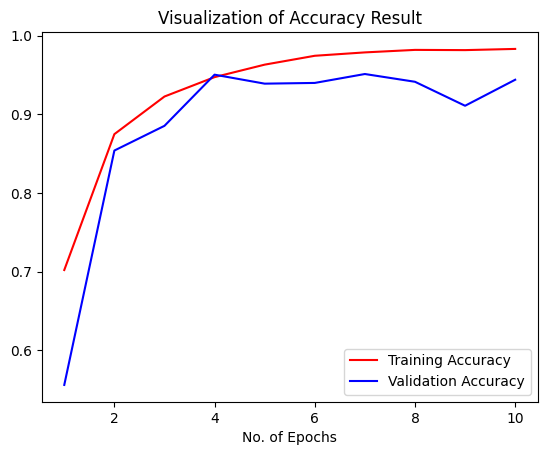

In [ ]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1,11)]
plt.plot(epochs,history.history['accuracy'],color='red',label='Training Accuracy')
plt.plot(epochs,history.history['val_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

In [ ]:
#Validation set Accuracy
model = tf.keras.models.load_model('best_model.keras')
val_loss, val_acc = model.evaluate(test_images)
print('Validation accuracy:', val_acc)

85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.9488 - loss: 0.1460
Validation accuracy: 0.9503728747367859
